## Use of VFA methods
The goal of this notebook is to show if it is possible to use VFA methods in the Slimevolley gym environment.

In [1]:
from os.path import join
from slime import Slime
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
import gym
import slimevolleygym
from algorithms import *


# Define our input folders and output files
DATADIR = join('..', 'data')
MODELDIR = join('..', 'models')
SAMPLES_FILE = 'sampled_states.csv'

TRAIN_FLAG = False

In [2]:
if TRAIN_FLAG:
    slime = Slime('BSLN')
    random_ss = slime.sample_states(10_000, 'RANDOM')
    bsln_ss = slime.sample_states(1_000_000, 'MODEL')

    head = 'x_agent,y_agent,xdot_agent,ydot_agent,' \
        'x_ball,y_ball,xdot_ball,ydot_ball,' \
        'x_opponent,y_opponent,xdot_opponent,ydot_opponent'
        
    def save_ss_file(ss, name):
        np.savetxt(fname=join(DATADIR, name),
                X=ss,
                fmt='%.5f',
                delimiter=',',
                header=head,
                comments='')
        
    save_ss_file(random_ss, "ss_random.csv")
    save_ss_file(bsln_ss, "ss_bsln.csv")

We read the file `sampled_states.csv`. This is a database which contains 1M observations of the simulation of the agent playing with the opponent, both using the baseline policy (based on neural net)

In [3]:
ss_random = pd.read_csv(join(DATADIR, 'ss_random.csv'))
ss_bsln = pd.read_csv(join(DATADIR, 'ss_bsln.csv'))

We create a normalized dataframe `ss_norm`.

In [4]:
scaler = MinMaxScaler()
ss_random_norm = scaler.fit_transform(ss_random)
ss_bsln_norm = scaler.fit_transform(ss_bsln)
        

We create 3 `MiniBatchKMeans` estimators with 10K, 25K and 50K clusters and a batch size of 2048 and fit it with our normalized sampled states dataframe. The purpose of this is to reduce the information of our sampled states in a number clusters, which will be the centroids of the RBF used in the next cells.

In [5]:
if TRAIN_FLAG:
    mbkm_model_10 = MiniBatchKMeans(n_clusters=10_000, random_state=0, batch_size=2048, verbose=True)
    mbkm_model_10.fit(ss_bsln_norm)      # 6min

In [6]:
if TRAIN_FLAG:
    mbkm_model_25 = MiniBatchKMeans(n_clusters=25_000, random_state=0, batch_size=2048, verbose=True)
    mbkm_model_25.fit(ss_bsln_norm)      # 21min

In [7]:
if TRAIN_FLAG:
    mbkm_model_50 = MiniBatchKMeans(n_clusters=50_000, random_state=0, batch_size=2048, verbose=True)
    mbkm_model_50.fit(ss_bsln_norm)

We save the `cluster_centers_` from our `mbkm_model`in a file called `centroids_10K.csv`. This step is done so that we do not need to execute the clustering algorithm every time we want to use the centroids.

In [8]:
if TRAIN_FLAG:
    def save_centroids_file(model, name):
        head = 'x_agent,y_agent,xdot_agent,ydot_agent,' \
            'x_ball,y_ball,xdot_ball,ydot_ball,' \
            'x_opponent,y_opponent,xdot_opponent,ydot_opponent'        
        np.savetxt(fname=join(DATADIR, name),
            X=model.cluster_centers_,
            fmt='%.5f',
            delimiter=',',
            header=head,
            comments='')
        
    save_centroids_file(mbkm_model_10, "c_10.csv")
    save_centroids_file(mbkm_model_25, "c_25.csv")
    save_centroids_file(mbkm_model_50, "c_50.csv")

We save the information of the centroids from our files in a dataframe called `centroids_XX`. The shape of this dataframe will be 10K, 25K or 50K rows (depending on the number of clusters selected in our algorithm) by 12 columns (number of dimensions of the states of our environment).

In [9]:
centroids_10 = pd.read_csv(join(DATADIR, "c_10.csv"))
centroids_25 = pd.read_csv(join(DATADIR, "c_25.csv"))
centroids_50 = pd.read_csv(join(DATADIR, "c_50.csv"))

We create the definition of the function for the feature vector, which is encapsulated in a Featurizer class.

In [10]:
# Example for normalized state [0]
slime_env = gym.make('SlimeVolley-v0')
featurizer_10 = Featurizer(slime_env.observation_space, centroids_10)
x_10 = featurizer_10.feature_vector(ss_bsln_norm[0, :])
featurizer_25 = Featurizer(slime_env.observation_space, centroids_25)
x_25 = featurizer_25.feature_vector(ss_bsln_norm[0, :])
featurizer_50 = Featurizer(slime_env.observation_space, centroids_50, 0.3)
x_50 = featurizer_50.feature_vector(ss_bsln_norm[0, :])

In [11]:
slime_env = gym.make('SlimeVolley-v0')

### 10K centroids

In [43]:
q = ValueFunction(featurizer_10, slime_env.action_space.n)
slime_q, slime_history, slime_history_average = semi_gradient_sarsa(slime_env, q, 1000) # alpha and epsilon values by defaultº

episodio 100: alfa = 0.1, epsilon = 0.1, retorno medio = -4.848484848484849
episodio 200: alfa = 0.1, epsilon = 0.1, retorno medio = -4.864321608040201


KeyboardInterrupt: 

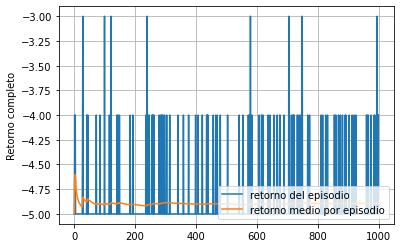

In [ ]:
plot_history(slime_history, slime_history_average)

In [16]:
slime_q, slime_history, slime_history_average = semi_gradient_n_step_sarsa(
    slime_env, q, 1000, n = 4, alpha=0.05)

episodio 100: alfa = 0.05, epsilon = 0.1, retorno medio = -4.858585858585859
episodio 200: alfa = 0.05, epsilon = 0.1, retorno medio = -4.839195979899498
episodio 300: alfa = 0.05, epsilon = 0.1, retorno medio = -4.862876254180602
episodio 400: alfa = 0.05, epsilon = 0.1, retorno medio = -4.857142857142857
episodio 500: alfa = 0.05, epsilon = 0.1, retorno medio = -4.865731462925852
episodio 600: alfa = 0.05, epsilon = 0.1, retorno medio = -4.869782971619365
episodio 700: alfa = 0.05, epsilon = 0.1, retorno medio = -4.868383404864091
episodio 800: alfa = 0.05, epsilon = 0.1, retorno medio = -4.867334167709637
episodio 900: alfa = 0.05, epsilon = 0.1, retorno medio = -4.872080088987764
episodio 1000: alfa = 0.05, epsilon = 0.1, retorno medio = -4.877877877877878


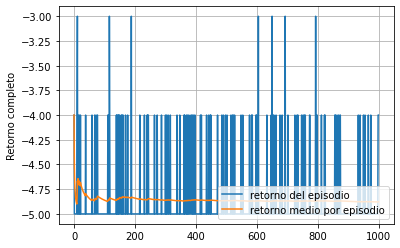

In [17]:
plot_history(slime_history, slime_history_average)

### 25K centroids

In [12]:
q = ValueFunction(featurizer_25, slime_env.action_space.n)
slime_q, slime_history, slime_history_average = semi_gradient_sarsa(slime_env, q, 1000) # alpha and epsilon values by defaultº

episodio 100: alfa = 0.1, epsilon = 0.1, retorno medio = -4.8686868686868685
episodio 200: alfa = 0.1, epsilon = 0.1, retorno medio = -4.8542713567839195
episodio 300: alfa = 0.1, epsilon = 0.1, retorno medio = -4.842809364548495
episodio 400: alfa = 0.1, epsilon = 0.1, retorno medio = -4.844611528822055
episodio 500: alfa = 0.1, epsilon = 0.1, retorno medio = -4.861723446893787
episodio 600: alfa = 0.1, epsilon = 0.1, retorno medio = -4.856427378964941
episodio 700: alfa = 0.1, epsilon = 0.1, retorno medio = -4.84549356223176
episodio 800: alfa = 0.1, epsilon = 0.1, retorno medio = -4.83854818523154
episodio 900: alfa = 0.1, epsilon = 0.1, retorno medio = -4.839822024471635
episodio 1000: alfa = 0.1, epsilon = 0.1, retorno medio = -4.8408408408408405


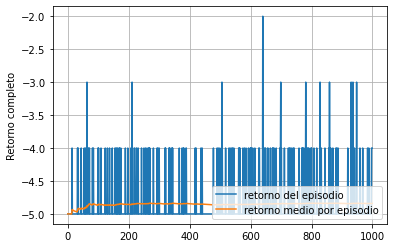

In [13]:
plot_history(slime_history, slime_history_average)

In [14]:
slime_q, slime_history, slime_history_average = semi_gradient_n_step_sarsa(
    slime_env, q, 1000, n = 4, alpha=0.05)

episodio 100: alfa = 0.05, epsilon = 0.1, retorno medio = -4.858585858585859
episodio 200: alfa = 0.05, epsilon = 0.1, retorno medio = -4.85929648241206
episodio 300: alfa = 0.05, epsilon = 0.1, retorno medio = -4.869565217391305
episodio 400: alfa = 0.05, epsilon = 0.1, retorno medio = -4.87468671679198
episodio 500: alfa = 0.05, epsilon = 0.1, retorno medio = -4.86372745490982
episodio 600: alfa = 0.05, epsilon = 0.1, retorno medio = -4.869782971619365
episodio 700: alfa = 0.05, epsilon = 0.1, retorno medio = -4.86409155937053
episodio 800: alfa = 0.05, epsilon = 0.1, retorno medio = -4.869837296620776
episodio 900: alfa = 0.05, epsilon = 0.1, retorno medio = -4.867630700778643
episodio 1000: alfa = 0.05, epsilon = 0.1, retorno medio = -4.870870870870871


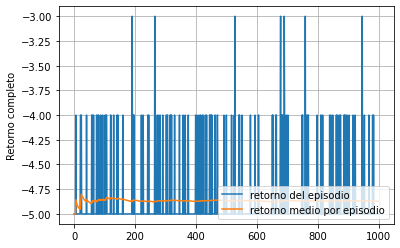

In [15]:
plot_history(slime_history, slime_history_average)

### 50K centroids

In [16]:
q_50 = ValueFunction(featurizer_50, slime_env.action_space.n)
slime_q_50, slime_history_50, slime_history_average_50 = semi_gradient_sarsa(slime_env, q_50, 1000) # alpha and epsilon values by defaultº

episodio 100: alfa = 0.1, epsilon = 0.1, retorno medio = -4.929292929292929
episodio 200: alfa = 0.1, epsilon = 0.1, retorno medio = -4.919597989949748
episodio 300: alfa = 0.1, epsilon = 0.1, retorno medio = -4.906354515050167
episodio 400: alfa = 0.1, epsilon = 0.1, retorno medio = -4.889724310776942
episodio 500: alfa = 0.1, epsilon = 0.1, retorno medio = -4.891783567134269
episodio 600: alfa = 0.1, epsilon = 0.1, retorno medio = -4.886477462437395
episodio 700: alfa = 0.1, epsilon = 0.1, retorno medio = -4.889842632331903
episodio 800: alfa = 0.1, epsilon = 0.1, retorno medio = -4.882352941176471
episodio 900: alfa = 0.1, epsilon = 0.1, retorno medio = -4.880978865406007
episodio 1000: alfa = 0.1, epsilon = 0.1, retorno medio = -4.878878878878879


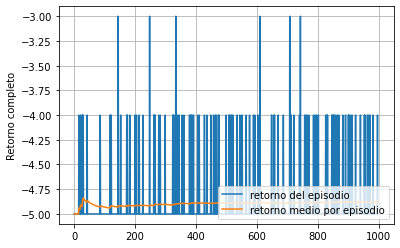

In [17]:
plot_history(slime_history_50, slime_history_average_50)

In [18]:
slime_q, slime_history, slime_history_average = semi_gradient_n_step_sarsa(
    slime_env, q, 1000, n = 4, alpha=0.05)

episodio 100: alfa = 0.05, epsilon = 0.1, retorno medio = -4.878787878787879
episodio 200: alfa = 0.05, epsilon = 0.1, retorno medio = -4.869346733668341
episodio 300: alfa = 0.05, epsilon = 0.1, retorno medio = -4.8762541806020065


KeyboardInterrupt: 

In [ ]:
plot_history(slime_history, slime_history_average)